# **Library**

In [ ]:
!pip install rouge

In [ ]:
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import json
import gc
import os
import copy
import time
import re
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from textwrap import wrap
from transformers import AutoModel, AutoProcessor,  AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

# **PREPARE DATASET**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train/kaggle/working/traindata.csv')
train_list_image = list(train_df['name'])
train_list_caption = list(train_df['caption'])
train_root = '/content/drive/MyDrive/Colab Notebooks/train/kaggle/working/train_images/'
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test/kaggle/working/testdata.csv')
test_list_image = list(test_df['name'])
test_list_caption = list(test_df['caption'])
test_root = '/content/drive/MyDrive/Colab Notebooks/test/kaggle/working/test_images/'

In [ ]:
demo_image = [test_root+i for i in test_list_image[-10:]]
demo_caption = test_list_caption[-10:]

In [ ]:
def wrap_caption(caption, width=30):
    return wrap(caption, width=width)

In [ ]:
def get_demo_image():
  global demo_image
  global demo_caption
  rows = 4
  cols = 5
  fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
  for i in range(len(demo_image)):
    im = Image.open(demo_image[i])
    row = i // 5
    col = i % 5
    ax = axes[row * 2, col]
    ax_caption = axes[row * 2 + 1, col]
    ax.imshow(im)
    ax.axis('off')
    wrapped_caption = wrap_caption(demo_caption[i],20)
    ax_caption.text(0.5, 0.5, '\n'.join(wrapped_caption), ha='center', va='center', fontsize=10)
    ax_caption.axis('off')
  plt.tight_layout()
  plt.show()


In [ ]:
def get_train_image(num=5):
  global train_list_image
  global train_list_caption
  global train_root
  rows = 2
  cols = num
  fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
  order = np.random.permutation(len(train_list_image))[:num]
  for idx,i in enumerate(order):
    im = Image.open(train_root+train_list_image[i])
    row = idx // num
    col = idx % num
    ax = axes[row * 2, col]
    ax_caption = axes[row * 2 + 1, col]
    ax.imshow(im)
    ax.axis('off')
    wrapped_caption = wrap_caption(train_list_caption[i],20)
    ax_caption.text(0.5, 0.5, '\n'.join(wrapped_caption), ha='center', va='center', fontsize=10)
    ax_caption.axis('off')
  plt.tight_layout()
  plt.show()
def get_test_image(num=5):
  global test_list_image
  global test_list_caption
  global test_root
  rows = 2
  cols = num
  fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
  order = np.random.permutation(len(test_list_image))[:num]
  for idx,i in enumerate(order):
    im = Image.open(test_root+test_list_image[i])
    row = idx // num
    col = idx % num
    ax = axes[row * 2, col]
    ax_caption = axes[row * 2 + 1, col]
    ax.imshow(im)
    ax.axis('off')
    wrapped_caption = wrap_caption(test_list_caption[i],20)
    ax_caption.text(0.5, 0.5, '\n'.join(wrapped_caption), ha='center', va='center', fontsize=10)
    ax_caption.axis('off')
  plt.tight_layout()
  plt.show()

# **Look into Dataset**

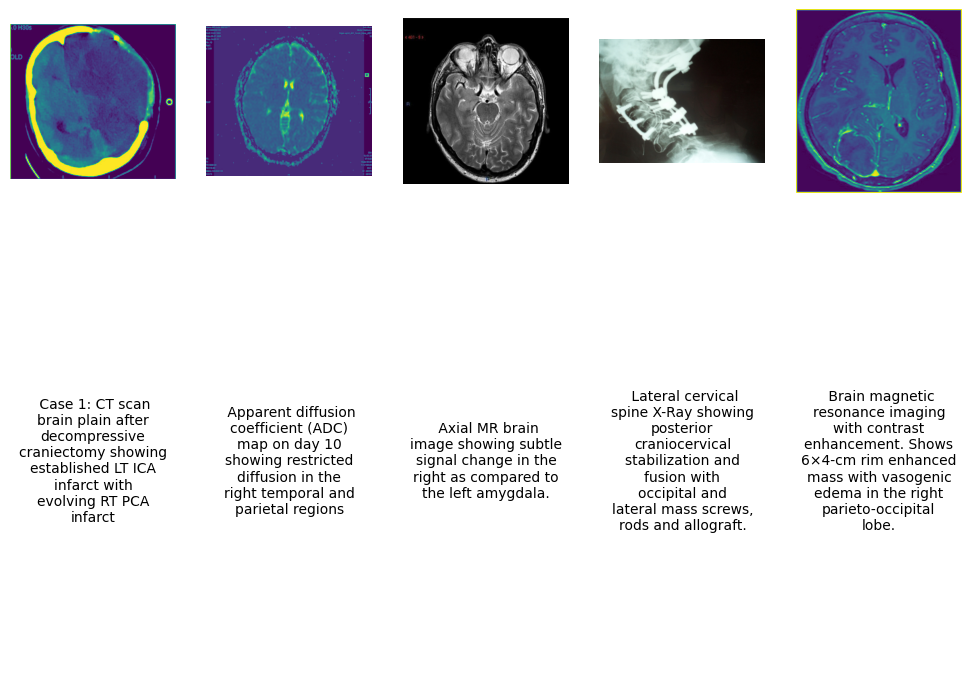

In [ ]:
get_train_image(5)

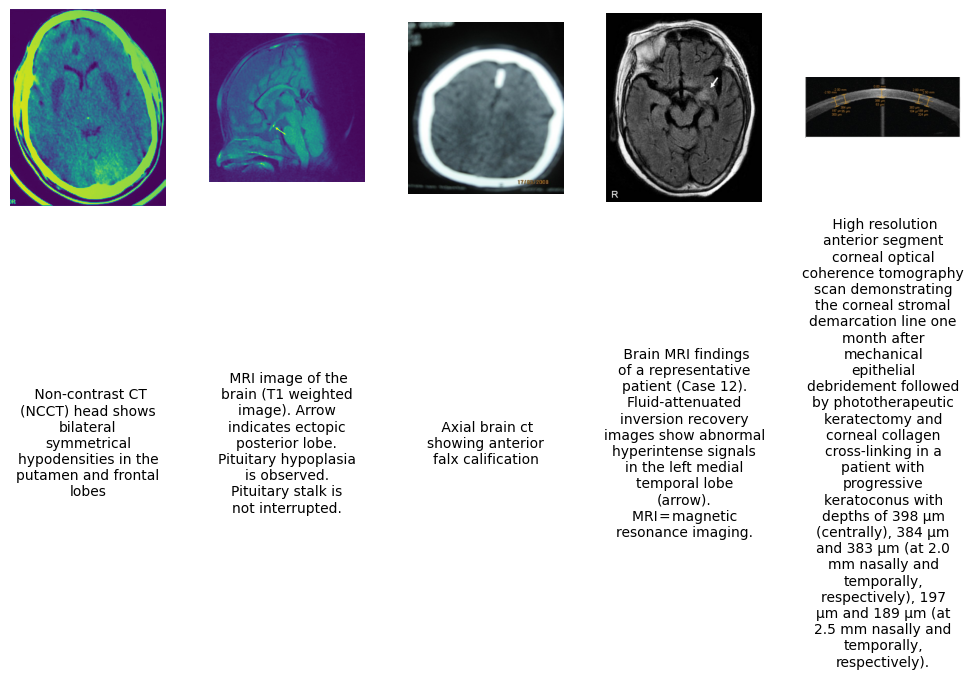

In [ ]:
get_test_image(5)

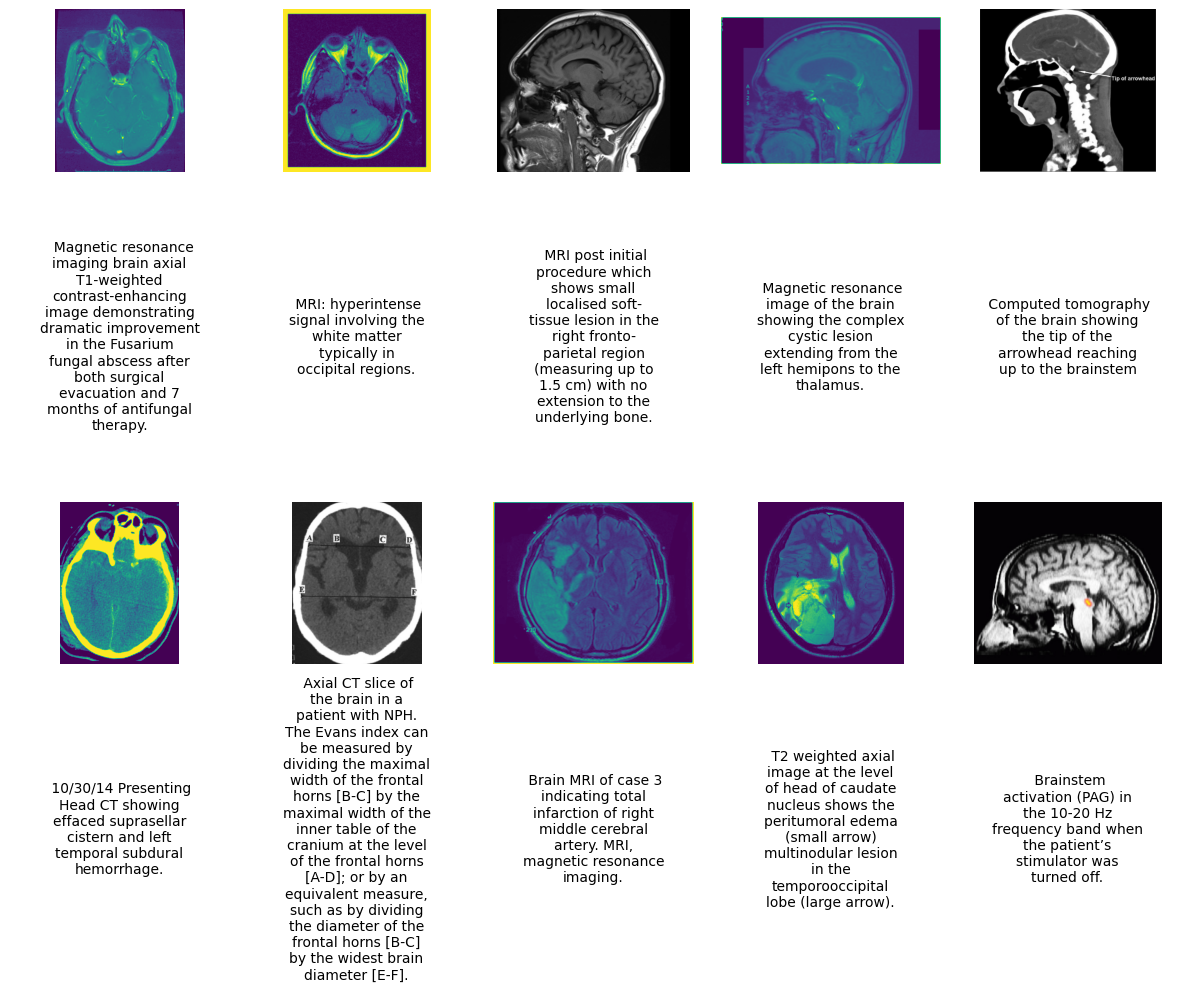

In [ ]:
get_demo_image()

# **Result**

## **Git Model**

### Util thing for GIT

In [ ]:
def process_log_file(file_path):
    result_dict = {}
    pattern = re.compile(r'epoch: (\d+) batch: (\d+) -----------loss:([\d.]+)')
    with open(file_path, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                epoch = int(match.group(1))
                batch = int(match.group(2))
                loss = float(match.group(3))
                if epoch not in result_dict:
                    result_dict[epoch] = {}
                result_dict[epoch][batch] = loss
    return result_dict

In [ ]:
def draw_loss():
  train_log = process_log_file('/content/drive/MyDrive/Colab Notebooks/Result/GIT/log.txt')
  batch_loss = []
  epoch_loss = []
  for k,v in train_log.items():
    batch_loss += list(v.values())
    epoch_loss.append(np.mean(list(v.values())))
  fig, ax=plt.subplots(1, 2, figsize=(12, 8))
  ax[0].plot(batch_loss)
  ax[0].title.set_text('Training batch loss \n last 60 epochs')
  ax[0].set_ylabel('loss')
  ax[1].plot(epoch_loss)
  ax[1].title.set_text('Training epoch loss \n last 60 epochs')
  plt.show()

In [ ]:
def compute_bleu_score(reference,candidate,ngram=4):
  weights = [1/ngram]*ngram
  return  sentence_bleu([reference], candidate,weights=weights)
def compute_rouge_score( reference_sentence,predicted_sentence,):
    rouge = Rouge()
    scores = rouge.get_scores(predicted_sentence, reference_sentence)
    return scores

### **Load git model**

In [ ]:
git_processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
git_model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")
git_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Result/GIT/ROCO_Git (1).pth',map_location='cpu'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

<All keys matched successfully>

### Model architecture

In [ ]:
git_model

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

### training loss

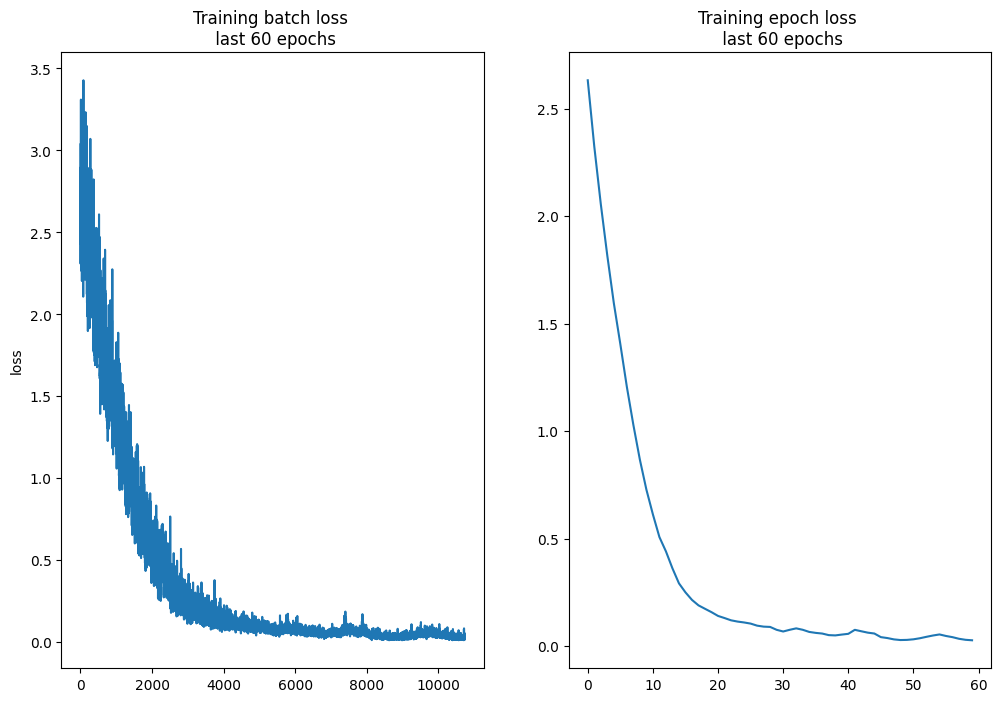

In [ ]:
draw_loss()

### Result of GIT

In [ ]:
git_result_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result/GIT/result.csv')
git_result_df

,expected output,output
0,['brain magnetic resonance imaging ( mri ) aft...,['brain magnetic resonance imaging ( mri ) aft...
1,['twelve - year - old boy presented with nasop...,['axial noncontrast computed tomography of the...
2,['an hc with a diameter of 0. 37 cm in the lef...,['the t1 - weighted mri image of the brain sho...
3,['pmmr of hypoxic brain changes. axial t2 - we...,['fluid - attenuated inversion recovery magnet...
4,['ct scan of the brain showing a solitary meta...,['postcontrast ct scan of brain showing regres...
...,...,...
328,['mr t2 axial image showing contusion of the b...,['t2w axial image of brain showing bilateral o...
329,"[""75 - year - old man with amygdala enlargemen...",['pet / ct images showing high to low fdg upta...
330,['t2 - weighted brain mri : note periventricul...,['brain mri of the first patient at the age of...
331,['magnetic resonance image. preoperative magne...,['post - contrast sagittal t1 - weighted seque...


In [ ]:
git_result_df['bleu2'] = git_result_df.apply(
    lambda x: compute_bleu_score(git_processor(text=x['expected output'])['input_ids'],
                                 git_processor(text=x['output'])['input_ids'],2
                                 ), axis=1)
git_result_df['bleu3'] = git_result_df.apply(
    lambda x: compute_bleu_score(git_processor(text=x['expected output'])['input_ids'],
                                 git_processor(text=x['output'])['input_ids'],3
                                 ), axis=1)
git_result_df['bleu4'] = git_result_df.apply(
    lambda x: compute_bleu_score(git_processor(text=x['expected output'])['input_ids'],
                                 git_processor(text=x['output'])['input_ids'],3
                                 ), axis=1)
print(f"everage bleu score when using ngrams = 2: {np.mean(list(git_result_df['bleu2']))}")
print(f"everage bleu score when using ngrams = 3: {np.mean(list(git_result_df['bleu3']))}")
print(f"everage bleu score when using ngrams = 4: {np.mean(list(git_result_df['bleu4']))}")

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


everage bleu score when using ngrams = 2: 0.2244085083222495
everage bleu score when using ngrams = 3: 0.17153852520756194
everage bleu score when using ngrams = 4: 0.17153852520756194


In [ ]:
git_result_df['rouge-1'] = git_result_df.apply(
    lambda x: compute_rouge_score(x['expected output'],
                                 x['output']
                                 )[0]['rouge-1']['f'], axis=1)
git_result_df['rouge-2'] = git_result_df.apply(
    lambda x: compute_rouge_score(x['expected output'],
                                 x['output']
                                 )[0]['rouge-2']['f'], axis=1)
git_result_df['rouge-l'] = git_result_df.apply(
    lambda x: compute_rouge_score(x['expected output'],
                                 x['output']
                                 )[0]['rouge-l']['f'], axis=1)
print(f"everage rouge-1 f1 score:{np.mean(list(git_result_df['rouge-1']))}")
print(f"everage rouge-2 f1 score:{np.mean(list(git_result_df['rouge-2']))}")
print(f"everage rouge-l f1 score:{np.mean(list(git_result_df['rouge-l']))}")

everage rouge-1 f1 score:0.25079220372713634
everage rouge-2 f1 score:0.08076691711377516
everage rouge-l f1 score:0.22913274358404553


### demo

model output: ['flair mri brain showing hyperintense signal on bilateral occipital and cerebellar hemispheres.']
expected output:  MRI: hyperintense signal involving the white matter typically in occipital regions.



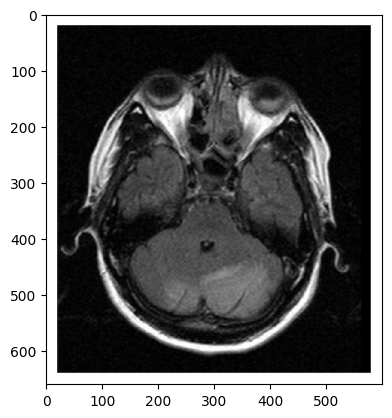

In [ ]:
idx = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
git_model.to(device)
im = Image.open(demo_image[idx]).convert('RGB')
pixel_values = git_processor(images = im,return_tensors='pt')["pixel_values"].to(device)
output = git_model.generate(pixel_values=pixel_values,max_length=700)
plt.imshow(im)
plt.plot()
print('model output:',git_processor.batch_decode(output,skip_special_tokens=True))
print('expected output:',demo_caption[idx])

In [ ]:
print("LLMs score")
print("Bard: 0.41044776119402987")
print("GPT-3.5: 0.26336633663366343")
print("GPT-4: 0.2780487804878049")

LLMs score
Bard: 0.41044776119402987
GPT-3.5: 0.26336633663366343
GPT-4: 0.2780487804878049
